---

## Inspiration for this Model
 I was in high school attending public school in downtown Chicago. I remember sometimes being afraid of civil unrest, especially surrounding high-profile court cases and during COVID-19. I remember experiencing teacher strikes, crazy winter storms, and other volatile activity, thinking: is it still safe to take the L blue line train to school today?

## What data will I use?
 I will use the GDELT database to identify violent events. Specifically, I will pull events with the code **145X** from the GDELT Event Database. We'll first visualize the data and then decide how to build our model.

---

--- 

Loading testing Data

In [3]:
# You might need to install these packages here
# %pip install keras
# %pip install tensorflow

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense

import matplotlib.pyplot as plt

In [6]:
# Load the test data
test_data = pd.read_csv('chicago_violent_protests_test.csv')

# Display the first few rows of the dataframe
test_data.head()

,0
0,1
1,2
2,1
3,1
4,1


Loading training data

In [7]:
# Load the training data
train_data = pd.read_csv('chicago_violent_protests_train.csv')

# Display the first few rows of the dataframe
train_data.head()

,0
0,1
1,0
2,0
3,0
4,0


Data loaded! Let's move on.

---

---

Let's understand the distribution of civil unrest activity on a given day.

---

In [ ]:
import matplotlib.pyplot as plt

## THIS IS NOT CORRECT - DIDN'T ACOCUNT FOR DAYS WITHOUT EVENTS

# Group the data by date and count the number of events per day
events_per_day = data.groupby('SQLDATE').size()

# Calculate mean and standard deviation
mean_events = events_per_day.mean()
std_events = events_per_day.std()

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot histogram with log scale on the first subplot
ax1.hist(events_per_day, bins=30, alpha=0.7, color='skyblue', label='Log Scale')
ax1.set_yscale('log')
ax1.set_xlabel('Number of Events')
ax1.set_ylabel('Frequency (log scale)')
ax1.set_title('Histogram of Number of Unrest Activities in One Day (Log Scale)')
ax1.grid(True)

# Plot histogram with linear scale on the second subplot
ax2.hist(events_per_day, bins=30, alpha=0.7, color='orange', label='Linear Scale')
ax2.set_xlabel('Number of Events')
ax2.set_ylabel('Frequency (linear scale)')
ax2.set_title('Histogram of Number of Unrest Activities in One Day (Linear Scale)')
ax2.grid(True)

# Add vertical lines for mean and standard deviations
for ax in [ax1, ax2]:
    ax.axvline(mean_events, color='red', linestyle='--', linewidth=1.5, label='Mean')
    ax.axvline(mean_events + std_events, color='green', linestyle='--', linewidth=1.5, label='1 SD')
    
    ax.axvline(mean_events + 2 * std_events, color='blue', linestyle='--', linewidth=1.5, label='2 SD')
    
    ax.axvline(mean_events + 3 * std_events, color='purple', linestyle='--', linewidth=1.5, label='3 SD')

# Remove duplicate legend entries
handles, labels = ax1.get_legend_handles_labels()
unique_legend = dict(zip(labels, handles))
ax1.legend(unique_legend.values(), unique_legend.keys())

handles, labels = ax2.get_legend_handles_labels()
unique_legend = dict(zip(labels, handles))
ax2.legend(unique_legend.values(), unique_legend.keys())

# Show the plot
plt.tight_layout()
plt.show()


NameError: name 'data' is not defined

---

I included a logorithmic distribution becuase clearly most days in Chicago have very few events (thank God!). I also included the SD of events in the graph, to see how rare some of the events were. However, this is not normally distributed, so it's not really the most relevant of an input.

---

---

Now I want to better understand the relationship between AvgTone and these events. 

---

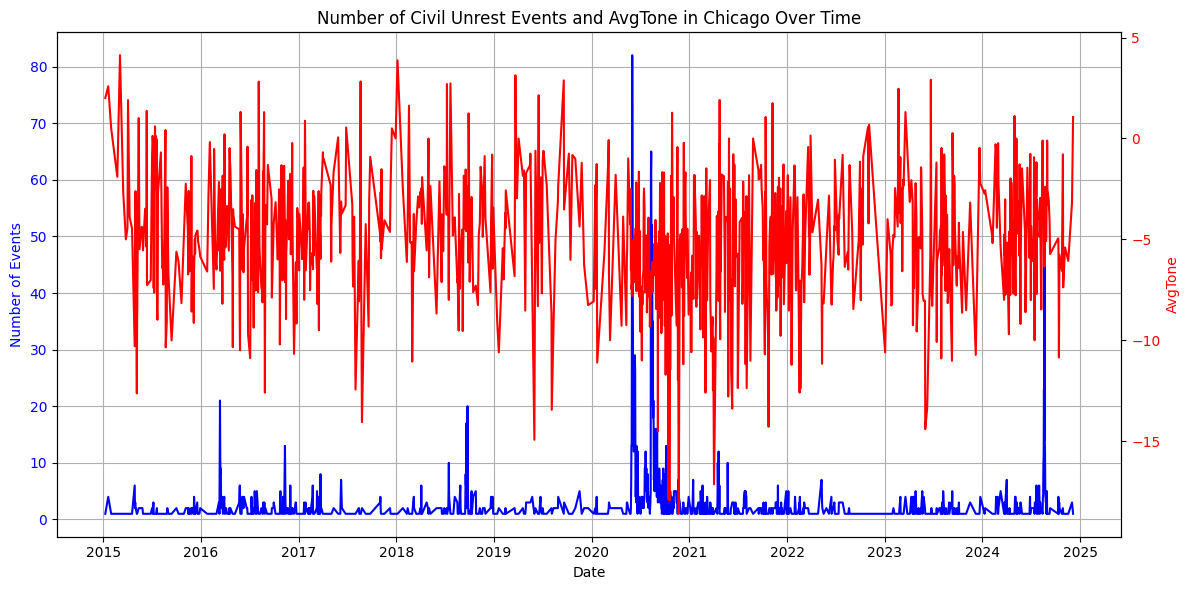

In [ ]:
# Aggregate data for plotting
grouped_data = data.groupby('SQLDATE').agg({'EventCode': 'size', 'AvgTone': 'mean'}).reset_index()

# Create the figure and first axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the number of events over time
ax1.plot(grouped_data['SQLDATE'], grouped_data['EventCode'], color='blue', label='Number of Events')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Events', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis to plot AvgTone
ax2 = ax1.twinx()
ax2.plot(grouped_data['SQLDATE'], grouped_data['AvgTone'], color='red', label='AvgTone')
ax2.set_ylabel('AvgTone', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add title and grid
plt.title('Number of Civil Unrest Events and AvgTone in Chicago Over Time')
ax1.grid(True)

# Optimize layout and show the plot
fig.tight_layout()
plt.show()


I ended up not using AvgTone. It looks honestly like noise. I might include it in the model in the future, but not now.

---

---

## Building the Model

The goal would be to take the last 7 days of data, and use it to predict the next day. I want to build a model that predicts the number of civil unrest events that will occur in the next 24 hrs.

Let's attempt the LSTM model.

---

--- 

Data formatting. We want a $\vec X$ of the historical data, and map it to $Y$, the output. 

It'll require some manipulation of the exisitng data.

---

In [4]:
test_X = []
test_Y = []
for i in range(7, len(test_data)):
    test_X.append(tuple(test_data.iloc[i-7:i]))
    test_Y.append(test_data.iloc[i])

train_X = []
train_Y = []
for i in range(7, len(train_data)):
    train_X.append((tuple(train_data.iloc[i-7:i])))
    train_Y.append(train_data.iloc[i])

Let's make a few modifications and then build the model.

In [8]:
# Convert lists to numpy arrays
import numpy as np

test_X = np.array(test_X)
test_Y = np.array(test_Y)
train_X = np.array(train_X)
train_Y = np.array(train_Y)

# Reshape the data to fit the model input requirements
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(train_X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(train_X, train_Y, epochs=10, verbose=1)

NameError: name 'Sequential' is not defined

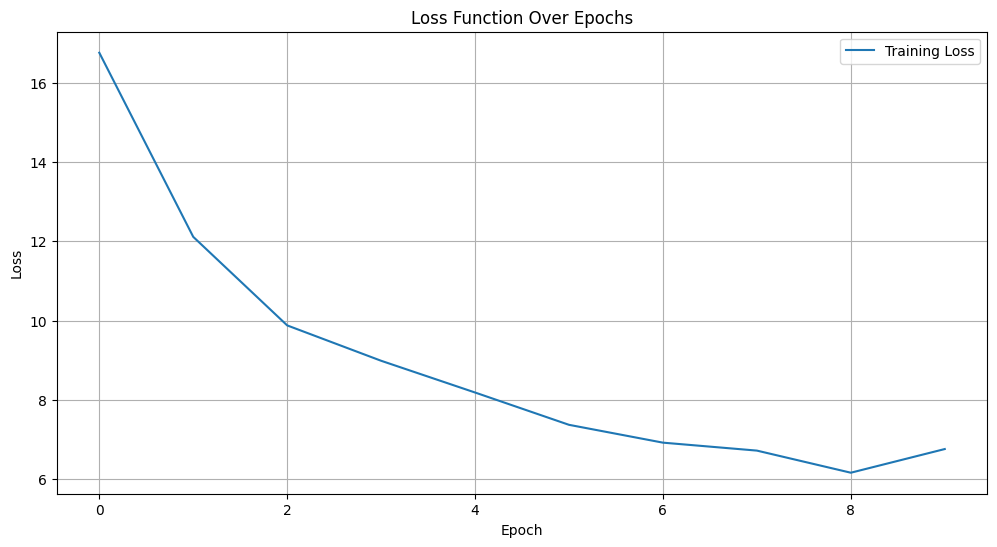

In [ ]:
# Plot the loss function over the epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss Function Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

---

Predictions:

In [ ]:
# Make predictions on the test data
predictions = model.predict(test_X)

# Adjust the index to start on 2021-01-01
adjusted_index = pd.date_range(start='2021-01-01', periods=len(test_Y), freq='D')

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


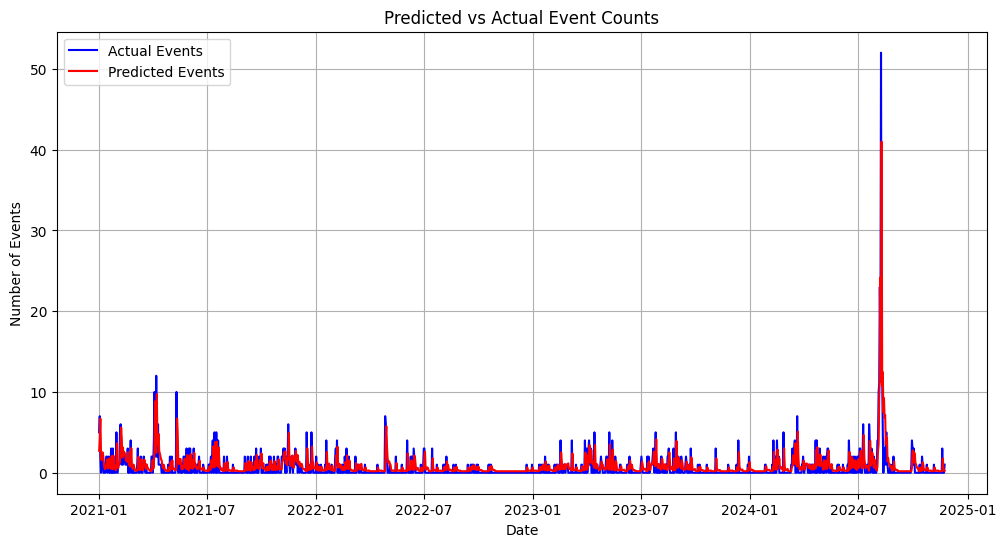

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(adjusted_index, test_Y, label='Actual Events', color='blue')
plt.plot(adjusted_index, predictions, label='Predicted Events', color='red')
plt.title('Predicted vs Actual Event Counts')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend()
plt.grid(True)
plt.show()

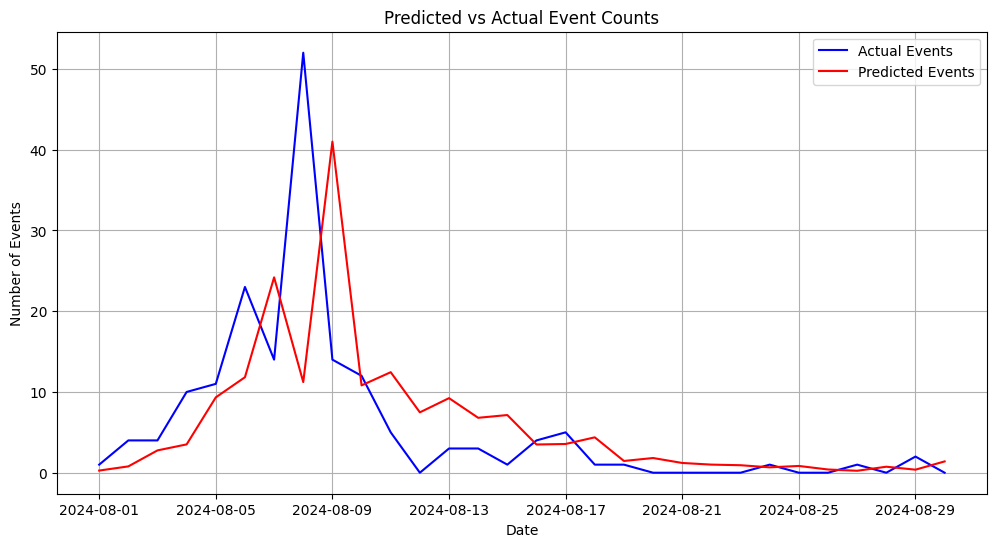

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(adjusted_index[1308:1338], test_Y[1308:1338], label='Actual Events', color='blue')
plt.plot(adjusted_index[1308:1338:], predictions[1308:1338], label='Predicted Events', color='red')
plt.title('Predicted vs Actual Event Counts')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend()
plt.grid(True)
plt.show()

---

The model actually seemed to predict the DNC protests that occured in Chicago!

The greatest area for improvement in this model would be to reduce the lag in the model. It really helps when protests start to ramp up, because the model picks up on this and then predicts a growth in the civil unrest events. 

However, this almost defeats the point if you are a day late from knowing when protest peak. You already went to school or work.

I could have an off-by-1 error in my code. That would be more realistic. I'm I'm frankly pretty shocked the model was so accurate. I need to double check there's no error in the training & testing data.

If I accidentlly trained on the test data, that would be a huge error. I'll need to double check my work. 

---

---

### Error Correction

I need to double check to see if there's overfitting or if the model is being trained on test data. I'll probably refactor my code to make it better to double check, and then see if these results hold.

### Expanding and Improving

Then I might improve the model to see if I can predict 2 days out. I might include more inputs like S&P performance, inflation, violitility indexes, semantic news data, and more to improve the model in the future.

---